In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from tqdm import tqdm
import acd
from copy import deepcopy
from model_mnist import LeNet5
from visualize import *
import dset_mnist as dset
import foolbox
sys.path.append('../trim')
from transforms_torch import transform_bandpass, tensor_t_augment, batch_fftshift2d, batch_ifftshift2d
from trim import *
from util import *
from attributions import *
from captum.attr import *
import warnings
warnings.filterwarnings("ignore")
# disentangled vae
sys.path.append('../disentangling-vae')
from collections import defaultdict
import vae_trim, vae_trim_viz
from disvae.utils.modelIO import save_model, load_model, load_metadata
from disvae.models.losses import get_loss_f

In [162]:
args = vae_trim.parse_arguments()
args.name = "disvae_btcvae_B_3"
# results dir
exp_dir = os.path.join(vae_trim.RES_DIR, args.name)

# load dataloaders
train_loader, test_loader = dset.load_data(args.batch_size, args.eval_batchsize, device)
metadata = load_metadata(exp_dir)

# load vae
model = load_model(exp_dir, is_gpu=not args.no_cuda)

# load classifier
m = LeNet5().eval()
m.load_state_dict(torch.load('weights/lenet_epoch=12_test_acc=0.991.pth'))
m = m.to(device)
# test model
# dset.test(m, test_loader, args)

In [163]:
# transform
def t(x):
    mean, _ = model.encoder(x)
    return mean
transform_i = lambda x: model.decoder(x)

# prepend model
m_t = TrimModel(m, transform_i, use_residuals=True)

In [164]:
# get samples
data = iter(train_loader).next()
inputs, labels = data
inputs = inputs.to(device)
labels = labels.to(device)

# trim score
s = t(inputs)
# attributer = InputXGradient(m_t)
attributer = IntegratedGradients(m_t)
attributions = attributer.attribute(s, target=labels, additional_forward_args=deepcopy(inputs))
# standardization
mean = attributions.mean(dim=1, keepdim=True)
std = attributions.std(dim=1, keepdim=True)
attributions = (attributions - mean) / std
attributions = attributions.detach().cpu().numpy()

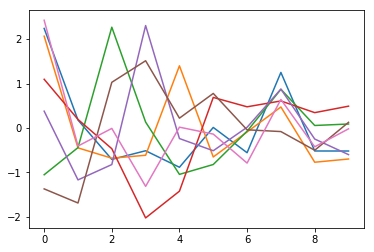

In [165]:
for idx in np.argwhere(labels.detach().cpu().numpy() == 0).flatten():
    plt.plot(attributions[idx])

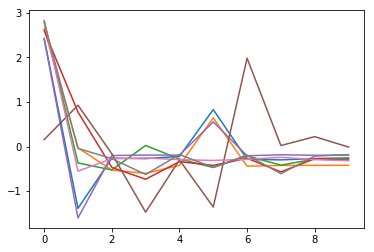

In [166]:
for idx in np.argwhere(labels.detach().cpu().numpy() == 1).flatten():
    plt.plot(attributions[idx])

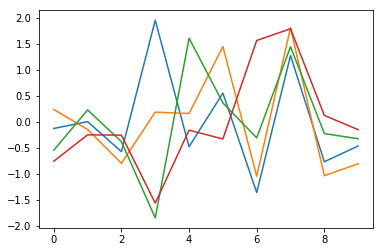

In [167]:
for idx in np.argwhere(labels.detach().cpu().numpy() == 2).flatten():
    plt.plot(attributions[idx])

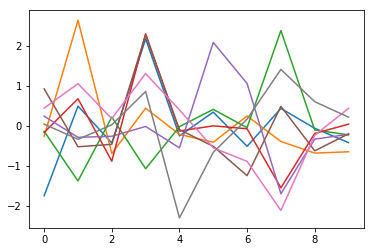

In [168]:
for idx in np.argwhere(labels.detach().cpu().numpy() == 3).flatten():
    plt.plot(attributions[idx])

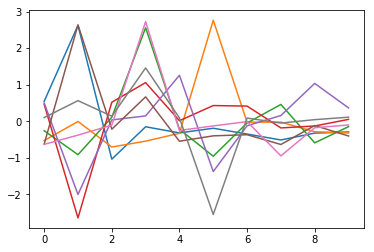

In [169]:
for idx in np.argwhere(labels.detach().cpu().numpy() == 4).flatten():
    plt.plot(attributions[idx])

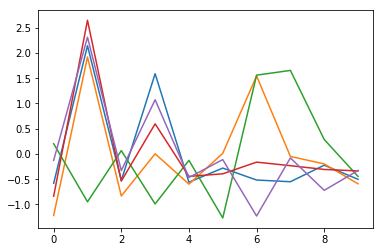

In [170]:
for idx in np.argwhere(labels.detach().cpu().numpy() == 7).flatten():
    plt.plot(attributions[idx])

## Visualize filters

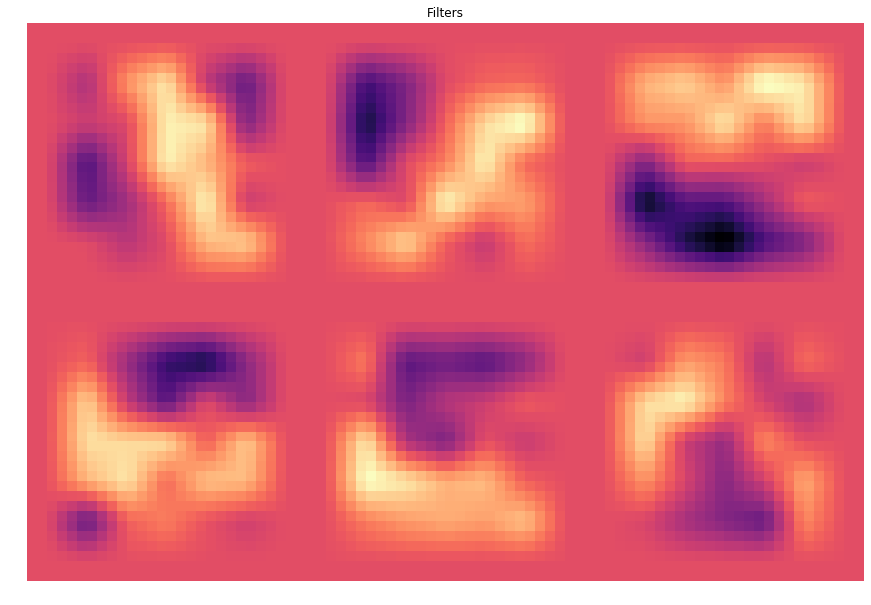

In [174]:
# viz filters
viz_tensors(m.convnet.c1.weight.squeeze(), n_row=2, n_col=3, normalize=False)

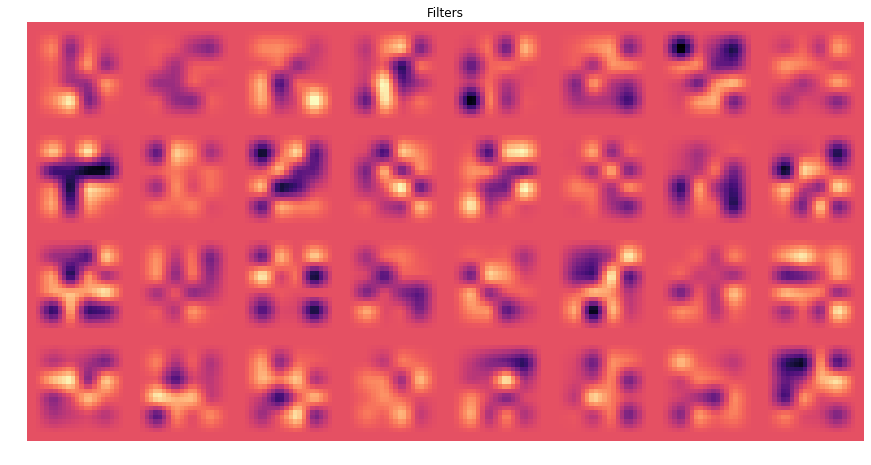

In [175]:
# viz filters
viz_tensors(model.encoder.conv1.weight.squeeze(), n_row=4, n_col=8, normalize=False)

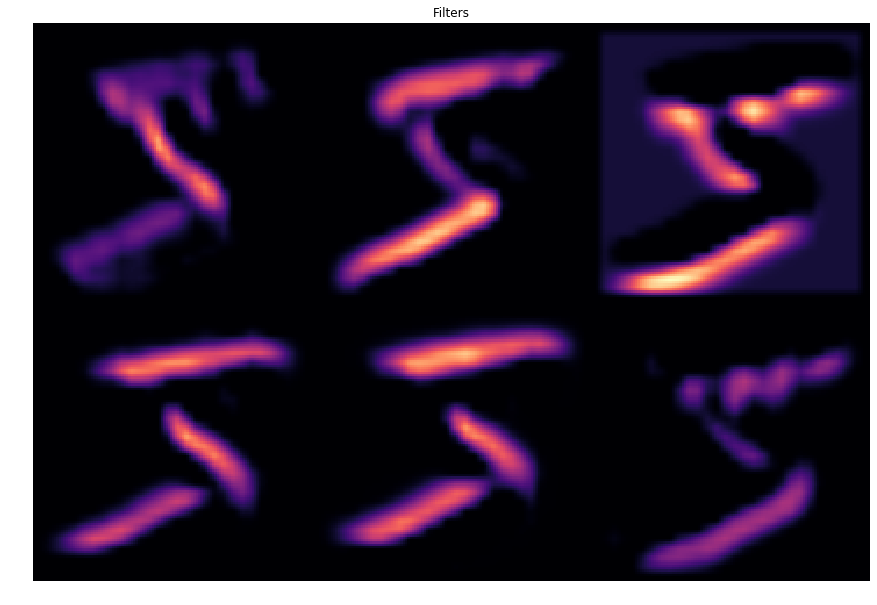

In [176]:
# viz filters
viz_tensors(F.relu(m.convnet.c1(inputs))[0], n_row=2, n_col=3, normalize=False)

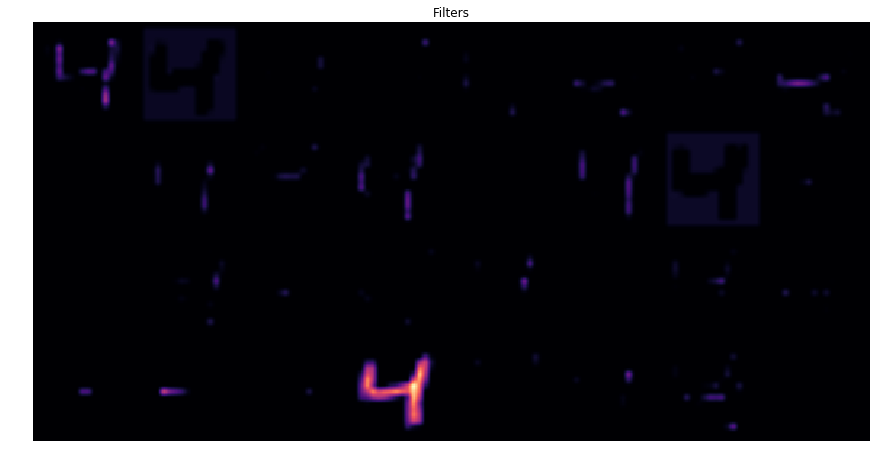

In [179]:
# viz filter
viz_tensors(F.relu(model.encoder.conv1(inputs))[2], n_row=4, n_col=8, normalize=False)

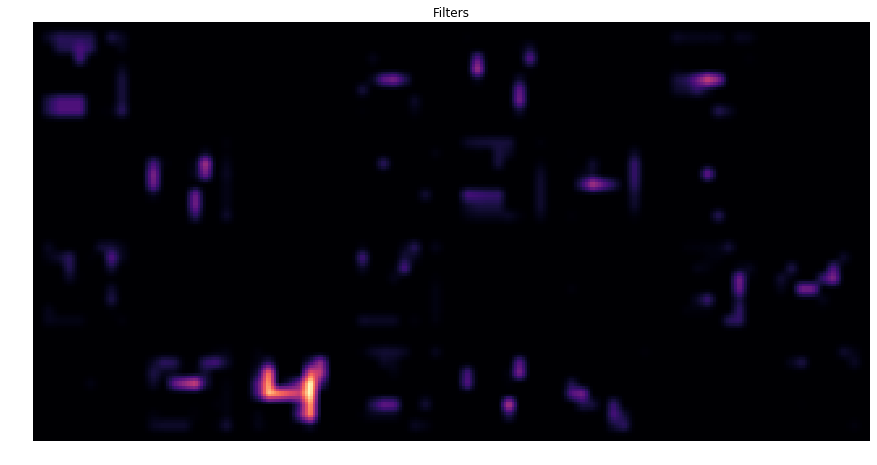

In [180]:
# viz filter
viz_tensors(F.relu(model.encoder.conv2(F.relu(model.encoder.conv1(inputs))))[2], n_row=4, n_col=8, normalize=False)

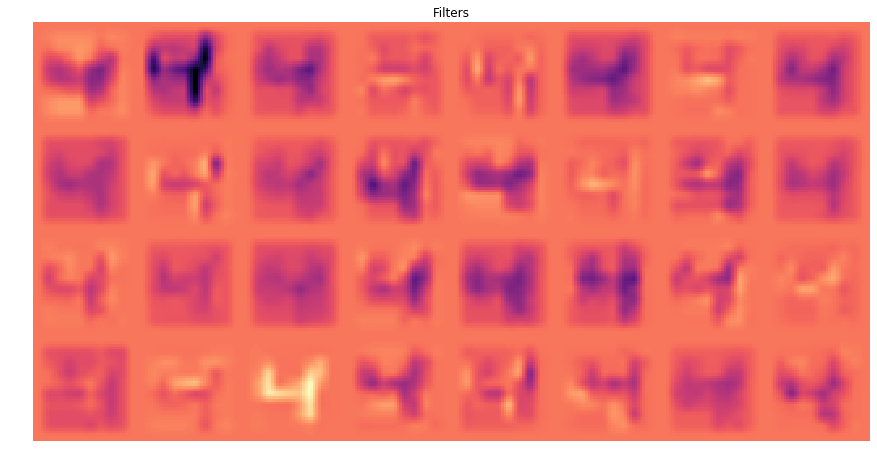

In [181]:
# viz filter
viz_tensors((model.encoder.conv2(F.relu(model.encoder.conv1(inputs))))[2], n_row=4, n_col=8, normalize=False)

In [182]:
f = open("results/disvae_btcvae_B_3/train_losses.log")